In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import glob
from tqdm import tqdm
import tensorflow as tf
import keras
import numpy as np
import cv2
import seaborn as sns
from keras.models import Sequential, Model
from keras.layers import Activation,Dense, Dropout, Flatten, Conv2D, MaxPool2D,AveragePooling2D,GlobalMaxPooling2D
from keras.layers import BatchNormalization
from keras.utils.np_utils import to_categorical
from keras import regularizers
from keras.optimizers import Adam, SGD
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

In [3]:
# Encoding Target values
lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

# Reading input images
path = 'input/'

#Dictionary for Image Names
image_path_dict = {os.path.splitext(os.path.basename(x))[0]: x for x in glob.glob(os.path.join(path, '*.jpg'))}

#Read Metadata csv
skin_df = pd.read_csv('HAM10000_metadata.csv')

#Create useful Columns - Images Path, Lesion Type and Lesion Categorical Code
skin_df['path'] = skin_df['image_id'].map(image_path_dict.get)
skin_df['cell_type'] = skin_df['dx'].map(lesion_type_dict.get) 
skin_df['cell_type_idx'] = pd.Categorical(skin_df['cell_type']).codes

In [4]:
image_path_dict

{'ISIC_0024306': 'input\\ISIC_0024306.jpg',
 'ISIC_0024307': 'input\\ISIC_0024307.jpg',
 'ISIC_0024308': 'input\\ISIC_0024308.jpg',
 'ISIC_0024309': 'input\\ISIC_0024309.jpg',
 'ISIC_0024310': 'input\\ISIC_0024310.jpg',
 'ISIC_0024311': 'input\\ISIC_0024311.jpg',
 'ISIC_0024312': 'input\\ISIC_0024312.jpg',
 'ISIC_0024313': 'input\\ISIC_0024313.jpg',
 'ISIC_0024314': 'input\\ISIC_0024314.jpg',
 'ISIC_0024315': 'input\\ISIC_0024315.jpg',
 'ISIC_0024316': 'input\\ISIC_0024316.jpg',
 'ISIC_0024317': 'input\\ISIC_0024317.jpg',
 'ISIC_0024318': 'input\\ISIC_0024318.jpg',
 'ISIC_0024319': 'input\\ISIC_0024319.jpg',
 'ISIC_0024320': 'input\\ISIC_0024320.jpg',
 'ISIC_0024321': 'input\\ISIC_0024321.jpg',
 'ISIC_0024322': 'input\\ISIC_0024322.jpg',
 'ISIC_0024323': 'input\\ISIC_0024323.jpg',
 'ISIC_0024324': 'input\\ISIC_0024324.jpg',
 'ISIC_0024325': 'input\\ISIC_0024325.jpg',
 'ISIC_0024326': 'input\\ISIC_0024326.jpg',
 'ISIC_0024327': 'input\\ISIC_0024327.jpg',
 'ISIC_0024328': 'input\\ISIC_00

In [5]:
skin_df

,lesion_id,image_id,dx,dx_type,age,sex,localization,dataset,path,cell_type,cell_type_idx
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,vidir_modern,input\ISIC_0027419.jpg,Benign keratosis-like lesions,2
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,vidir_modern,input\ISIC_0025030.jpg,Benign keratosis-like lesions,2
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,vidir_modern,input\ISIC_0026769.jpg,Benign keratosis-like lesions,2
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,vidir_modern,input\ISIC_0025661.jpg,Benign keratosis-like lesions,2
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,vidir_modern,input\ISIC_0031633.jpg,Benign keratosis-like lesions,2
...,...,...,...,...,...,...,...,...,...,...,...
10010,HAM_0002867,ISIC_0033084,akiec,histo,40.0,male,abdomen,vidir_modern,input\ISIC_0033084.jpg,Actinic keratoses,0
10011,HAM_0002867,ISIC_0033550,akiec,histo,40.0,male,abdomen,vidir_modern,input\ISIC_0033550.jpg,Actinic keratoses,0
10012,HAM_0002867,ISIC_0033536,akiec,histo,40.0,male,abdomen,vidir_modern,input\ISIC_0033536.jpg,Actinic keratoses,0
10013,HAM_0000239,ISIC_0032854,akiec,histo,80.0,male,face,vidir_modern,input\ISIC_0032854.jpg,Actinic keratoses,0


In [6]:
# Checking dataframe info
skin_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10015 entries, 0 to 10014
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   lesion_id      10015 non-null  object 
 1   image_id       10015 non-null  object 
 2   dx             10015 non-null  object 
 3   dx_type        10015 non-null  object 
 4   age            9958 non-null   float64
 5   sex            10015 non-null  object 
 6   localization   10015 non-null  object 
 7   dataset        10015 non-null  object 
 8   path           10015 non-null  object 
 9   cell_type      10015 non-null  object 
 10  cell_type_idx  10015 non-null  int8   
dtypes: float64(1), int8(1), object(9)
memory usage: 792.3+ KB


In [7]:
basic_EDA(skin_df)

Number of Samples: 10015,
Number of Features: 11,
Duplicated Entries: 0,
Null Entries:
lesion_id         0
image_id          0
dx                0
dx_type           0
age              57
sex               0
localization      0
dataset           0
path              0
cell_type         0
cell_type_idx     0
dtype: int64 ,
Number of Rows with Null Entries: 57 0.6%


In [8]:
summary_table(skin_df)

,Name,dtypes,Missing,Uniques
0,lesion_id,object,0,7470
1,image_id,object,0,10015
2,dx,object,0,7
3,dx_type,object,0,4
4,age,float64,57,18
5,sex,object,0,3
6,localization,object,0,15
7,dataset,object,0,4
8,path,object,0,10015
9,cell_type,object,0,7


In [9]:
# Filling NaN values in 'age' column with mode of samples
skin_df['age'].fillna((skin_df['age'].mode()), inplace=True)

In [10]:
# Image Reading and Resizing.
IMAGE_SIZE = 32
def read_img(img_path):
  img = cv2.imread(img_path,cv2.IMREAD_COLOR)
  img = cv2.resize(img,(IMAGE_SIZE,IMAGE_SIZE))
  return img
train_img = []
for img_name in tqdm(skin_df['path'].values):
  train_img.append(read_img(img_name))

100%|███████████████████████████████████████████████████████████████████████████| 10015/10015 [01:27<00:00, 114.55it/s]


In [11]:
# Converting it into float arrays and normalizing it
X = np.array(train_img,np.float32)/255
print(X.shape)

(10015, 32, 32, 3)


In [12]:
# Creating Target
y = np.array(skin_df['cell_type_idx'])

In [13]:
# Splitting the data
from sklearn.model_selection import train_test_split

x_train,x_test,y_train,y_test = train_test_split(X,y,test_size=0.20,stratify=y)

# Normalization
x_train_mean = np.mean(x_train)
x_train_std = np.std(x_train)

x_train = (x_train - x_train_mean)/x_train_std
x_test = (x_test - x_train_mean)/x_train_std

# Perform one-hot encoding on the labels
y_train = to_categorical(y_train, num_classes = 7)
y_test = to_categorical(y_test, num_classes = 7)

# Splitting training into Train and Validatation sets
x_train,x_val,y_train,y_val = train_test_split(x_train,y_train,test_size=0.20,random_state=128,stratify=y_train)

In [14]:
# Model Parameters
input_shape = (32, 32, 3)
num_classes = 7

optimizer = Adam(learning_rate=0.001)

epochs = 100
batch_size = 15

# Callbacks
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience=5, verbose=0, factor=0.5, min_lr=0.00001)
early_stopping_monitor = EarlyStopping(patience=20,monitor='val_accuracy')

# Data Augmentation
dataaugment = ImageDataGenerator(
        rotation_range=90,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=True,  # randomly flip images
        shear_range = 10) 

dataaugment.fit(x_train)

In [17]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),activation='relu',padding = 'Same',input_shape=input_shape))
model.add(BatchNormalization())
##############################
model.add(Conv2D(64, (3, 3), activation='relu',padding = 'Same'))
model.add(BatchNormalization())
model.add(AveragePooling2D(pool_size = (2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu',padding = 'Same'))
model.add(BatchNormalization())

model.add(Conv2D(64, (3, 3), activation='relu',padding = 'Same'))
model.add(BatchNormalization())
model.add(AveragePooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
##############################
model.add(Conv2D(64, (3, 3), activation='relu',padding = 'Same'))
model.add(BatchNormalization())
model.add(AveragePooling2D(pool_size = (2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu',padding = 'Same'))
model.add(BatchNormalization())

model.add(Conv2D(64, (3, 3), activation='relu',padding = 'Same'))
model.add(BatchNormalization())
model.add(AveragePooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
##############################
model.add(Flatten())

model.add(BatchNormalization())
model.add(Dense(128, activation='relu'))
model.add(Activation('relu'))
model.add(Dropout(0.25))

#Output
model.add(BatchNormalization())
model.add(Dense(num_classes, activation='softmax'))

In [20]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 64)        18496     
                                                                 
 batch_normalization_1 (Batc  (None, 32, 32, 64)       256       
 hNormalization)                                                 
                                                                 
 average_pooling2d (AverageP  (None, 16, 16, 64)       0         
 ooling2D)                                                       
                                                        

In [18]:
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

In [19]:
history = model.fit(dataaugment.flow(x_train,y_train, batch_size=batch_size),
                        epochs = epochs, validation_data = (x_val,y_val),
                        verbose = 1, callbacks=[learning_rate_reduction,early_stopping_monitor])

Epoch 1/100
427/427 [==============================] - 52s 113ms/step - loss: 1.3141 - accuracy: 0.5669 - val_loss: 0.9020 - val_accuracy: 0.6775 - lr: 0.0010
Epoch 2/100
427/427 [==============================] - 14s 32ms/step - loss: 0.9964 - accuracy: 0.6594 - val_loss: 0.8640 - val_accuracy: 0.6856 - lr: 0.0010
Epoch 3/100
427/427 [==============================] - 14s 34ms/step - loss: 0.9243 - accuracy: 0.6713 - val_loss: 0.8378 - val_accuracy: 0.6993 - lr: 0.0010
Epoch 4/100
427/427 [==============================] - 15s 34ms/step - loss: 0.9035 - accuracy: 0.6803 - val_loss: 0.9383 - val_accuracy: 0.6943 - lr: 0.0010
Epoch 5/100
427/427 [==============================] - 15s 34ms/step - loss: 0.8673 - accuracy: 0.6899 - val_loss: 0.8372 - val_accuracy: 0.6925 - lr: 0.0010
Epoch 6/100
427/427 [==============================] - 14s 33ms/step - loss: 0.8449 - accuracy: 0.6930 - val_loss: 0.8158 - val_accuracy: 0.7199 - lr: 0.0010
Epoch 7/100
427/427 [==============================

In [34]:
loss = history.history['loss']
accuracy = history.history['accuracy']
val_loss = history.history['val_loss']
val_accuracy = history.history['val_accuracy']

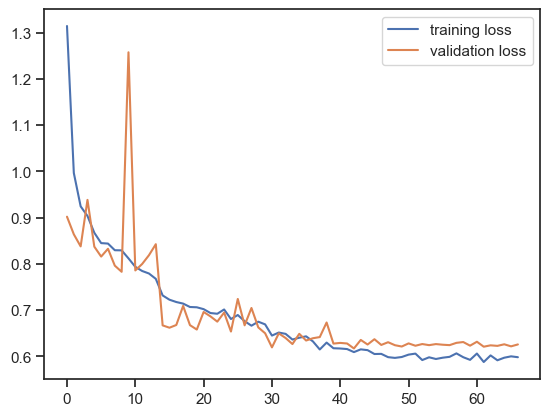

<Figure size 600x400 with 0 Axes>

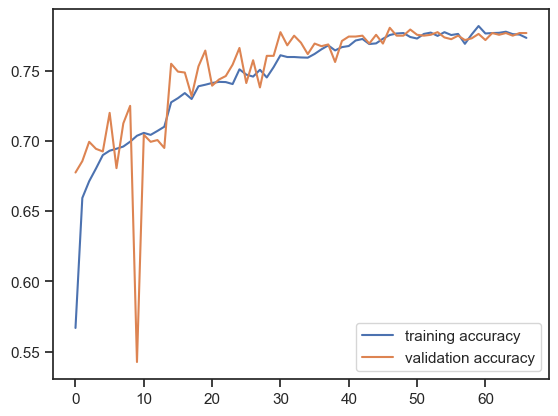

<Figure size 600x400 with 0 Axes>

In [35]:
plt.plot(range(len(loss)), loss, label="training loss")
plt.plot(range(len(val_loss)), val_loss, label="validation loss")
plt.legend(loc="upper right")
plt.figure(figsize=(6,4))
plt.show()
plt.plot(range(len(accuracy)), accuracy, label="training accuracy")
plt.plot(range(len(val_accuracy)), val_accuracy, label="validation accuracy")
plt.legend(loc="lower right")
plt.figure(figsize=(6,4))
plt.show()

In [23]:
model.save('prml_model.h5')

In [24]:
model.save_weights('prml_model_weights.h5')

In [15]:
final_model = keras.models.load_model('prml_model.h5')

In [16]:
final_model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

In [17]:
loss_t, accuracy_t = final_model.evaluate(x_train, y_train, verbose=1)
loss_v, accuracy_v = final_model.evaluate(x_val, y_val, verbose=1)
loss, accuracy = final_model.evaluate(x_test, y_test, verbose=1)
predictions = final_model.predict(x_test)

print("Training: accuracy = %f" % (accuracy_t))
print("Validation: accuracy = %f" % (accuracy_v))
print("Test: accuracy = %f" % (accuracy))

63/63 [==============================] - 1s 13ms/step
Training: accuracy = 0.786394
Validation: accuracy = 0.785402
Test: accuracy = 0.792811


In [18]:
y_test

array([[0., 0., 0., ..., 1., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.]], dtype=float32)

In [19]:
predictions

array([[3.4647275e-04, 7.4353087e-04, 2.4100591e-03, ..., 9.9183601e-01,
        4.4789491e-03, 1.4776895e-05],
       [3.0090353e-03, 6.7660636e-01, 2.0898506e-02, ..., 4.0478297e-02,
        6.8385210e-03, 2.3763470e-01],
       [4.9190544e-07, 2.8436186e-06, 4.9504092e-06, ..., 9.9975514e-01,
        1.3911142e-04, 3.5923149e-05],
       ...,
       [2.0589333e-03, 1.4087574e-03, 4.8873585e-02, ..., 6.9292092e-01,
        2.5398403e-01, 2.6652834e-04],
       [4.7723237e-02, 7.7426597e-03, 1.3646433e-01, ..., 3.1933033e-01,
        4.8244590e-01, 3.0697740e-04],
       [5.3980505e-01, 1.8081515e-01, 1.8579115e-01, ..., 1.2929878e-02,
        4.2728450e-02, 3.6095821e-03]], dtype=float32)

In [23]:
cm = confusion_matrix(y_test.argmax(axis=1),predictions.argmax(axis=1))
cm

array([[  33,    4,    9,    0,    9,   10,    0],
       [  18,   57,    8,    0,   12,    5,    3],
       [  12,    6,  130,    0,   46,   25,    1],
       [   4,    8,    3,    1,    6,    1,    0],
       [   1,   13,   40,    1, 1229,   55,    2],
       [   5,    2,   34,    0,   63,  115,    4],
       [   1,    2,    0,    0,    1,    1,   23]], dtype=int64)

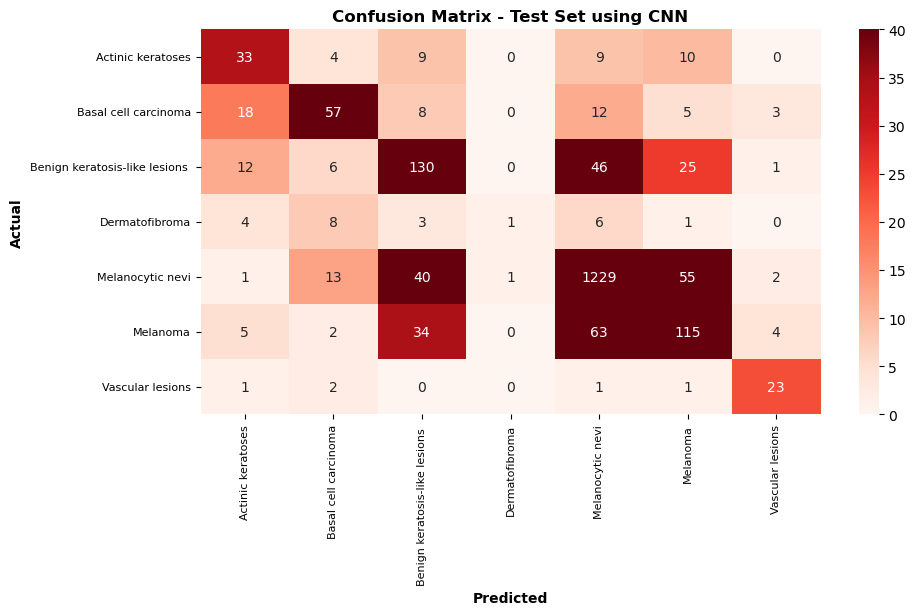

In [24]:
# PLotting Confusion Matrix
categories = ['Actinic keratoses', 'Basal cell carcinoma', 'Benign keratosis-like lesions ', 'Dermatofibroma', 'Melanocytic nevi', 'Melanoma', 'Vascular lesions']

CMatrix = pd.DataFrame( (cm) , columns=categories, index =categories)

plt.figure(figsize=(10, 5))
ax = sns.heatmap(CMatrix, annot = True, fmt = 'g' ,vmin = 0, vmax = 40,cmap = 'Reds')
ax.set_xlabel('Predicted',fontsize = 10,weight = 'bold')
ax.set_xticklabels(ax.get_xticklabels(), fontsize= 8);
ax.set_ylabel('Actual',fontsize = 10,weight = 'bold')
ax.set_yticklabels(ax.get_yticklabels(), fontsize=8)
ax.set_title('Confusion Matrix - Test Set using CNN',fontsize = 12,weight = 'bold');
plt.show()

In [101]:
# Calculating accuracy_score, precision_score, recall_score, f1_score using sklearn.metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

print('\nAccuracy: {:.2f}\n'.format(accuracy_score(y_test.argmax(axis=1),predictions.argmax(axis=1))))

print('Micro Precision: {:.2f}'.format(precision_score(y_test.argmax(axis=1),predictions.argmax(axis=1), average='micro')))
print('Micro Recall: {:.2f}'.format(recall_score(y_test.argmax(axis=1),predictions.argmax(axis=1), average='micro')))
print('Micro F1-score: {:.2f}\n'.format(f1_score(y_test.argmax(axis=1),predictions.argmax(axis=1), average='micro')))

print('Macro Precision: {:.2f}'.format(precision_score(y_test.argmax(axis=1),predictions.argmax(axis=1), average='macro')))
print('Macro Recall: {:.2f}'.format(recall_score(y_test.argmax(axis=1),predictions.argmax(axis=1), average='macro')))
print('Macro F1-score: {:.2f}\n'.format(f1_score(y_test.argmax(axis=1),predictions.argmax(axis=1), average='macro')))

print('Weighted Precision: {:.2f}'.format(precision_score(y_test.argmax(axis=1),predictions.argmax(axis=1), average='weighted')))
print('Weighted Recall: {:.2f}'.format(recall_score(y_test.argmax(axis=1),predictions.argmax(axis=1), average='weighted')))
print('Weighted F1-score: {:.2f}'.format(f1_score(y_test.argmax(axis=1),predictions.argmax(axis=1), average='weighted')))

print('\nClassification Report\n')
print(classification_report(y_test.argmax(axis=1),predictions.argmax(axis=1), target_names=categories))


Accuracy: 0.79

Micro Precision: 0.79
Micro Recall: 0.79
Micro F1-score: 0.79

Macro Precision: 0.61
Macro Recall: 0.56
Macro F1-score: 0.56

Weighted Precision: 0.79
Weighted Recall: 0.79
Weighted F1-score: 0.79

Classification Report

                                precision    recall  f1-score   support

             Actinic keratoses       0.45      0.51      0.47        65
          Basal cell carcinoma       0.62      0.55      0.58       103
Benign keratosis-like lesions        0.58      0.59      0.59       220
                Dermatofibroma       0.50      0.04      0.08        23
              Melanocytic nevi       0.90      0.92      0.91      1341
                      Melanoma       0.54      0.52      0.53       223
              Vascular lesions       0.70      0.82      0.75        28

                      accuracy                           0.79      2003
                     macro avg       0.61      0.56      0.56      2003
                  weighted avg       0.7

In [100]:
from sklearn.metrics import roc_auc_score

macro_roc_auc_ovo = roc_auc_score(y_test, predictions, multi_class="ovo", average="macro")
weighted_roc_auc_ovo = roc_auc_score(y_test, predictions, multi_class="ovo", average="weighted")

macro_roc_auc_ovr = roc_auc_score(y_test, predictions, multi_class="ovr", average="macro")
weighted_roc_auc_ovr = roc_auc_score(y_test, predictions, multi_class="ovr", average="weighted")

print("One-vs-One ROC AUC scores:\n{:.3f} (Macro),\n{:.3f} " "(Weighted)".format(macro_roc_auc_ovo, weighted_roc_auc_ovo))
print("One-vs-Rest ROC AUC scores:\n{:.3f} (Macro),\n{:.3f} " "(Weighted)".format(macro_roc_auc_ovr, weighted_roc_auc_ovr))

One-vs-One ROC AUC scores:
0.944 (Macro),
0.939 (Weighted)
One-vs-Rest ROC AUC scores:
0.944 (Macro),
0.939 (Weighted)


In [30]:
import sklearn.metrics as metrics

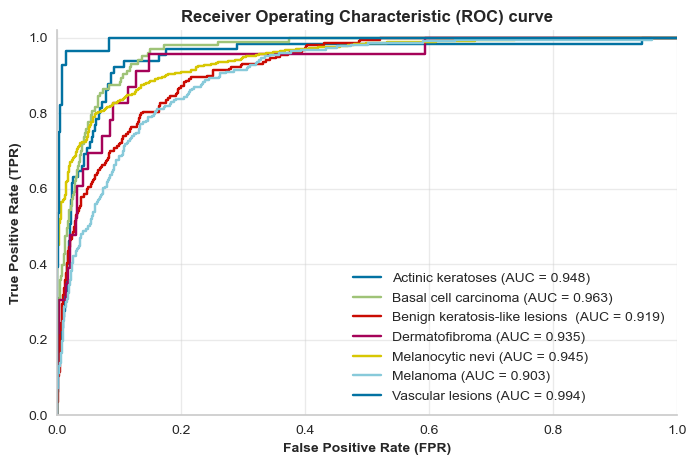

In [99]:
def plot_multiclass_roc(predictions, y_test, n_classes, figsize=(10, 5)):
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    predict_dummies = predictions
    y_test_dummies = y_test
    for i in range(n_classes):
        fpr[i], tpr[i], _ = metrics.roc_curve(y_test_dummies[:,i], predict_dummies[:,i])
        roc_auc[i] = metrics.auc(fpr[i], tpr[i])

    # roc for each class
    fig, ax = plt.subplots(figsize=figsize)
    ax.plot([2, 1], [2, 2], 'k--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.02])
    ax.set_xlabel('False Positive Rate (FPR)',fontsize = 10,weight = 'bold')
    ax.set_ylabel('True Positive Rate (TPR)',fontsize = 10,weight = 'bold')
    ax.set_title('Receiver Operating Characteristic (ROC) curve',fontsize = 12,weight = 'bold')
    for i in range(n_classes):
        ax.plot(fpr[i], tpr[i], label='%s (AUC = %0.3f)' % (categories[i], roc_auc[i]))
    ax.legend(loc="best")
    ax.grid(alpha=.4)
    sns.despine()
    plt.show()

plot_multiclass_roc(predictions, y_test, num_classes, figsize=(8, 5))